<a href="https://colab.research.google.com/github/eunicean/Proyecto-DeepLearning/blob/main/CNN/HIRAGANA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("farukece/handwritten-japanese-hiragana-characters")

print("Path to dataset files:", dataset_path)

Using Colab cache for faster access to the 'handwritten-japanese-hiragana-characters' dataset.
Path to dataset files: /kaggle/input/handwritten-japanese-hiragana-characters


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import Counter


In [4]:
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    # Solo mostrar los primeros niveles para no saturar
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Mostrar solo los primeros 5 archivos
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... y {len(files) - 5} archivos más')

    if level >= 3:
        break

handwritten-japanese-hiragana-characters/
  hiragana/
    nn/
    he/
    no/
    mu/
    na/
    se/
    so/
    wa/
    ko/
    yo/
    ra/
    wo/
    ta/
    ro/
    mo/
    ne/
    su/
    ii/
    nu/
    to/
    ri/
    chi/
    ke/
    te/
    ya/
    me/
    ma/
    mi/
    re/
    uu/
    fu/
    ho/
    tsu/
    ru/
    yu/
    shi/
    aa/
    ku/
    ni/
    oo/
    ki/
    hi/
    ee/
    ka/
    ha/
    sa/


In [5]:
# Analizar cada carpeta de hiragana
hiragana_path = os.path.join(dataset_path, "hiragana")

# Diccionario para almacenar la información
hiragana_data = {}

print("Conteo de imágenes por carácter Hiragana:")

for character_folder in sorted(os.listdir(hiragana_path)):
    folder_path = os.path.join(hiragana_path, character_folder)

    if os.path.isdir(folder_path):
        # Contar archivos de imagen
        image_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        hiragana_data[character_folder] = {
            'num_imagenes': len(image_files),
            'ruta': folder_path,
            'archivos': image_files
        }

        print(f"{character_folder:8s} tiene {len(image_files):3d} imágenes")

# Crear DataFrame para análisis
df_hiragana = pd.DataFrame.from_dict(hiragana_data, orient='index')
df_hiragana = df_hiragana.reset_index().rename(columns={'index': 'caracter'})

print("\n")
print(f"RESUMEN:")
print(f"Total de caracteres: {len(df_hiragana)}")
print(f"Total de imágenes: {df_hiragana['num_imagenes'].sum()}")
print(f"\nEstadísticas:")
print(f"  - Mínimo: {df_hiragana['num_imagenes'].min()} imágenes")
print(f"  - Máximo: {df_hiragana['num_imagenes'].max()} imágenes")
print(f"  - Promedio: {df_hiragana['num_imagenes'].mean():.2f} imágenes")
print(f"  - Mediana: {df_hiragana['num_imagenes'].median():.0f} imágenes")

# Verificar si todas las clases tienen 100 imágenes
clases_con_100 = df_hiragana[df_hiragana['num_imagenes'] == 100]
print(f"\nClases con exactamente 100 imágenes: {len(clases_con_100)}/{len(df_hiragana)}")

if len(df_hiragana) != len(clases_con_100):
    print("\nClases con cantidad diferente a 100:")
    clases_diferentes = df_hiragana[df_hiragana['num_imagenes'] != 100]
    for _, row in clases_diferentes.iterrows():
        print(f"  - {row['caracter']}: {row['num_imagenes']} imágenes")

Conteo de imágenes por carácter Hiragana:
aa       tiene 100 imágenes
chi      tiene 100 imágenes
ee       tiene 100 imágenes
fu       tiene 100 imágenes
ha       tiene 100 imágenes
he       tiene 100 imágenes
hi       tiene 100 imágenes
ho       tiene 100 imágenes
ii       tiene 100 imágenes
ka       tiene 100 imágenes
ke       tiene 100 imágenes
ki       tiene 100 imágenes
ko       tiene 100 imágenes
ku       tiene 100 imágenes
ma       tiene 100 imágenes
me       tiene 100 imágenes
mi       tiene 100 imágenes
mo       tiene 100 imágenes
mu       tiene 100 imágenes
na       tiene 100 imágenes
ne       tiene 100 imágenes
ni       tiene 100 imágenes
nn       tiene 100 imágenes
no       tiene 100 imágenes
nu       tiene 100 imágenes
oo       tiene 100 imágenes
ra       tiene 100 imágenes
re       tiene 100 imágenes
ri       tiene 100 imágenes
ro       tiene 100 imágenes
ru       tiene 100 imágenes
sa       tiene 100 imágenes
se       tiene 100 imágenes
shi      tiene 100 imágenes
so    

# División de datos en entrenamiento y prueba

In [6]:
from sklearn.model_selection import train_test_split
import shutil

# Configuración de la división
TRAIN_RATIO = 0.70  # 70% entrenamiento
VAL_RATIO = 0.15    # 15% validación
TEST_RATIO = 0.15   # 15% test

print(" Configuración de división del dataset:")
print("\n")
print(f"Train: {TRAIN_RATIO*100:.0f}% ({int(100*TRAIN_RATIO)} imágenes por clase)")
print(f"Validation: {VAL_RATIO*100:.0f}% ({int(100*VAL_RATIO)} imágenes por clase)")
print(f"Test: {TEST_RATIO*100:.0f}% ({int(100*TEST_RATIO)} imágenes por clase)")
print(f"\nTotal por clase: 100 imágenes")
print("\n")

# Crear estructura de directorios
base_output_path = "/content/hiragana_dataset"
splits = ['train', 'val', 'test']

# Crear carpetas
for split in splits:
    split_path = os.path.join(base_output_path, split)
    os.makedirs(split_path, exist_ok=True)
    print(f" Creado: {split_path}")

print("\nProcesando división del dataset...")

# Realizar la división estratificada para cada clase
np.random.seed(42)  # Para reproducibilidad

stats = {
    'train': 0,
    'val': 0,
    'test': 0
}

for character in sorted(df_hiragana['caracter']):
    # Obtener la ruta de la carpeta del carácter
    source_folder = os.path.join(hiragana_path, character)

    # Obtener lista de imágenes
    images = [f for f in os.listdir(source_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Mezclar aleatoriamente
    np.random.shuffle(images)

    # Calcular índices de división
    n_images = len(images)
    train_end = int(n_images * TRAIN_RATIO)
    val_end = train_end + int(n_images * VAL_RATIO)

    # Dividir las imágenes
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Crear carpetas para cada split
    for split in splits:
        split_char_path = os.path.join(base_output_path, split, character)
        os.makedirs(split_char_path, exist_ok=True)

    # Copiar imágenes a sus respectivas carpetas
    # TRAIN
    for img in train_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'train', character, img)
        shutil.copy2(src, dst)
        stats['train'] += 1

    # VALIDATION
    for img in val_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'val', character, img)
        shutil.copy2(src, dst)
        stats['val'] += 1

    # TEST
    for img in test_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'test', character, img)
        shutil.copy2(src, dst)
        stats['test'] += 1

print("\nDivisión completada!")
print("\nResumen de la división:")
print("\n")
print(f"Train:      {stats['train']:4d} imágenes ({stats['train']/4600*100:.1f}%)")
print(f"Validation: {stats['val']:4d} imágenes ({stats['val']/4600*100:.1f}%)")
print(f"Test:       {stats['test']:4d} imágenes ({stats['test']/4600*100:.1f}%)")
print(f"Total:      {sum(stats.values()):4d} imágenes")
print("\n")

 Configuración de división del dataset:


Train: 70% (70 imágenes por clase)
Validation: 15% (15 imágenes por clase)
Test: 15% (15 imágenes por clase)

Total por clase: 100 imágenes


 Creado: /content/hiragana_dataset/train
 Creado: /content/hiragana_dataset/val
 Creado: /content/hiragana_dataset/test

Procesando división del dataset...

División completada!

Resumen de la división:


Train:      3220 imágenes (70.0%)
Validation:  690 imágenes (15.0%)
Test:        690 imágenes (15.0%)
Total:      4600 imágenes




In [11]:
# Verificar la estructura creada
print("\nVerificación de la estructura:")


for split in splits:
    split_path = os.path.join(base_output_path, split)
    num_classes = len(os.listdir(split_path))

    total_images = 0
    for character in os.listdir(split_path):
        char_path = os.path.join(split_path, character)
        if os.path.isdir(char_path):
            num_images = len([f for f in os.listdir(char_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            total_images += num_images

    print(f"\n{split.upper()}:")
    print(f"  - Clases: {num_classes}")
    print(f"  - Total imágenes: {total_images}")
    print(f"  - Promedio por clase: {total_images/num_classes:.1f}")


Verificación de la estructura:

TRAIN:
  - Clases: 46
  - Total imágenes: 3220
  - Promedio por clase: 70.0

VAL:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0

TEST:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0


In [8]:
print()

for _file in os.scandir("/content/hiragana_dataset/test/aa"):

  if _file.is_file():
    print(_file.path)


from PIL import Image

# Path to your image file
image_path = "/content/hiragana_dataset/test/aa/drawing_20250805_081540.jpg"

try:
    # Open the image
    img = Image.open(image_path)

    # Get the size (width, height)
    width, height = img.size

    print(f"Image width: {width} pixels")
    print(f"Image height: {height} pixels")

except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")


/content/hiragana_dataset/test/aa/drawing_20250805_081540.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082208.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082124.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082306.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082120.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082347.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082034.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082144.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081601.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082333.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082253.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082141.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082302.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081639.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081902.jpg
Image width: 500 pixels
Image height: 400 pixels


Análisis de propiedades de imágenes:


Dimensiones encontradas: {(500, 400)}
Modos de color: {'RGB'}
Total analizado: 10 imágenes


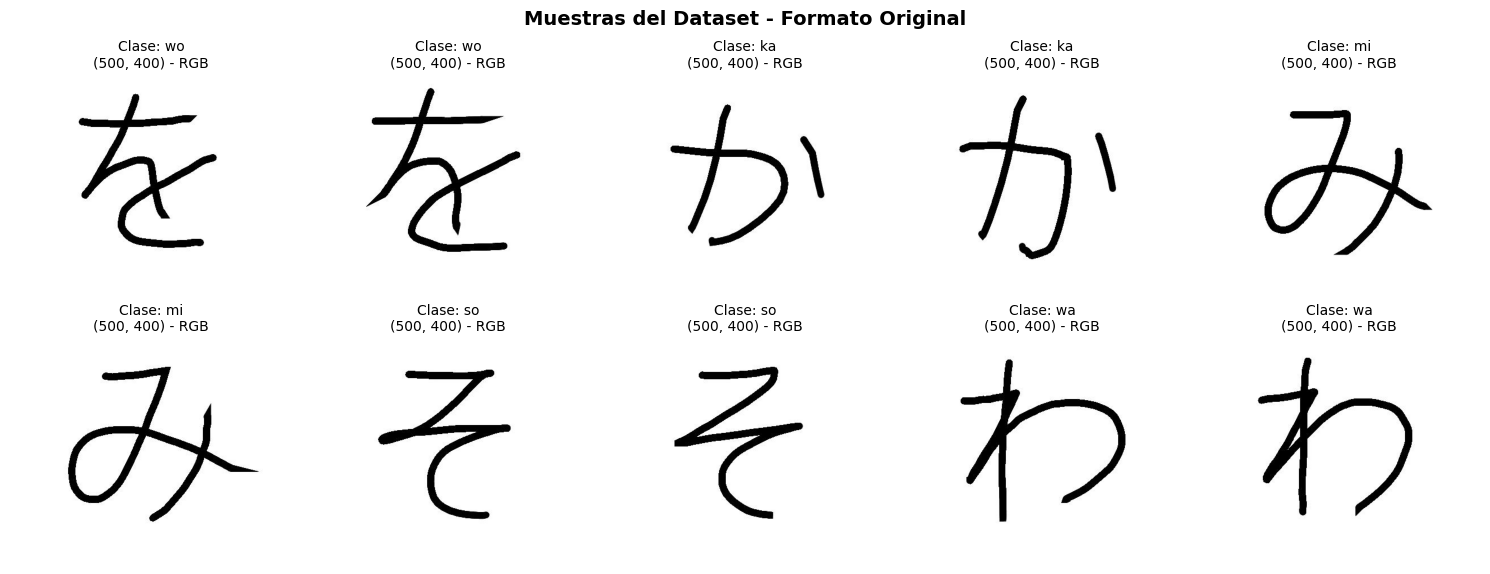

In [9]:
# Analizar propiedades de varias imágenes
import matplotlib.pyplot as plt

def analyze_image_properties(base_path, num_samples=10):
    """
    Analiza las propiedades de imágenes del dataset
    """
    print("Análisis de propiedades de imágenes:")
    print("\n")

    # Tomar muestras de diferentes clases
    train_path = os.path.join(base_path, 'train')
    classes = os.listdir(train_path)[:5]  # Primeras 5 clases

    sizes = []
    modes = []
    sample_images = []

    for cls in classes:
        class_path = os.path.join(train_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')][:2]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            sizes.append(img.size)
            modes.append(img.mode)
            sample_images.append((img, cls))

    # Estadísticas
    unique_sizes = set(sizes)
    unique_modes = set(modes)

    print(f"Dimensiones encontradas: {unique_sizes}")
    print(f"Modos de color: {unique_modes}")
    print(f"Total analizado: {len(sizes)} imágenes")

    return sample_images

# Analizar imágenes
samples = analyze_image_properties(base_output_path)

# Visualizar muestras
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (img, cls) in enumerate(samples):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Clase: {cls}\n{img.size} - {img.mode}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Muestras del Dataset - Formato Original', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Entrenamiento

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

print("Configuración entorno")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")


Configuración entorno
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:

# CONFIGURACIÓN DE HIPERPARÁMETROS
print("\nDefinición de hiperparámetros")
print("\n")

# Dimensiones de la imagen
IMG_HEIGHT = 64  # Altura a la que redimensionaremos
IMG_WIDTH = 64   # Ancho a la que redimensionaremos
IMG_CHANNELS = 1 # 1 = escala de grises, 3 = RGB

# Parámetros de entrenamiento
BATCH_SIZE = 32      # Cuántas imágenes procesa a la vez
EPOCHS = 20          # Cuántas veces pasa por todo el dataset
LEARNING_RATE = 0.001 # Qué tan grande son los pasos del optimizador

# Clases
NUM_CLASSES = 46     # Los 46 caracteres hiragana

print(f" Tamaño de imagen: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f" Batch size: {BATCH_SIZE}")
print(f" Epochs: {EPOCHS}")
print(f" Learning rate: {LEARNING_RATE}")
print(f" Número de clases: {NUM_CLASSES}")


Definición de hiperparámetros


 Tamaño de imagen: 64x64x1
 Batch size: 32
 Epochs: 20
 Learning rate: 0.001
 Número de clases: 46


In [18]:

# PREPARACIÓN DE LOS DATOS (SIN AUGMENTATION POR AHORA)
print("\nPreparación de generadores de datos")

# ImageDataGenerator: clase que carga y preprocesa imágenes automáticamente
# Explicación del preprocesamiento:
# 1. rescale=1./255: Divide cada píxel por 255 (convierte de 0-255 a 0-1)

# Generador para ENTRENAMIENTO (sin augmentation por ahora)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización: convierte valores de 0-255 a 0-1
)

# Generador para VALIDACIÓN (solo normalización)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generador para TEST (solo normalización)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Generadores creados (solo con normalización)")


Preparación de generadores de datos
Generadores creados (solo con normalización)
